# Visualizing/inspecting the learning rate over time and what the model learned

In [1]:
!nvidia-smi

Mon Jan 14 03:57:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   32C    P8    17W / 280W |   9470MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:81:00.0 Off |                  N/A |
|  0%   30C    P8    16W / 280W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
# !pip install joblib
# !echo "joblib" >> requirements.txt
# !pip freeze | grep -i torch >> requirements.txt
# !pip freeze | grep -i numpy >> requirements.txt
!cat requirements.txt

pytest
pytest-cov
joblib
torch==1.0.0
torchvision==0.2.1
scikit-learn==0.20.1
numpy==1.15.4


In [3]:
from src.data.read_txt import *
from src.data.config import *
from src.data.training_data import *
from src.data.sgnn_projection_layer import *
from src.model.loss import *
from src.model.transformer import *
from src.model.save_load_model import *
from src.training import *

import numpy as np
from sklearn.metrics import jaccard_similarity_score, f1_score, accuracy_score
from joblib import dump, load
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

import math
import copy
import time

In [4]:
batch_size = 160
train_iters_per_epoch = 24000
max_epoch = 11
cuda_device_id = 1  # None for CPU, 0 for first GPU, 1 for second GPU, etc.

In [5]:
!ls -1 models_weights/

my-model.pytorch.epoch_00000.notebook_run.gpu0
my-model.pytorch.epoch_00000.notebook_run.gpu1
my-model.pytorch.epoch_00001.notebook_run.gpu0
my-model.pytorch.epoch_00001.notebook_run.gpu1
my-model.pytorch.epoch_00002.notebook_run.gpu0
my-model.pytorch.epoch_00002.notebook_run.gpu1
my-model.pytorch.epoch_00003.notebook_run.gpu0
my-model.pytorch.epoch_00003.notebook_run.gpu1
my-model.pytorch.epoch_00004.notebook_run.gpu0
my-model.pytorch.epoch_00004.notebook_run.gpu1
my-model.pytorch.epoch_00005.notebook_run.gpu0
my-model.pytorch.epoch_00005.notebook_run.gpu1
my-model.pytorch.epoch_00006.notebook_run.gpu0
my-model.pytorch.epoch_00006.notebook_run.gpu1
my-model.pytorch.epoch_00007.notebook_run.gpu0
my-model.pytorch.epoch_00007.notebook_run.gpu1
my-model.pytorch.epoch_00008.notebook_run.gpu0
my-model.pytorch.epoch_00008.notebook_run.gpu1
my-model.pytorch.epoch_00009.notebook_run.gpu0
my-model.pytorch.epoch_00009.notebook_run.gpu1
my-model.pytorch.epoch_00010.notebook_run.gpu0
my-model.pyto

In [6]:
preproc_sgnn_sklearn_pipeline, sentence_projection_model = load_model(
    "my-model{}.epoch_00011.notebook_run.gpu0", cuda_device_id)
# preproc_sgnn_sklearn_pipeline, sentence_projection_model = load_most_recent_model(MY_MODEL_NAME, cuda_device_id)

Loaded model from files: ./models_weights/my-model.sklearn.epoch_00011.notebook_run.gpu0 ./models_weights/my-model.pytorch.epoch_00011.notebook_run.gpu0


In [7]:
model_trainer = TrainerModel(sentence_projection_model)

## Visualize the learning rate over time

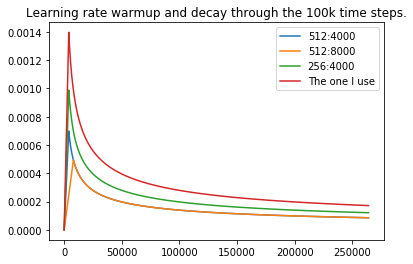

In [8]:
# Some code may derive from: https://github.com/harvardnlp/annotated-transformer
# MIT License, Copyright (c) 2018 Alexander Rush

import matplotlib.pyplot as plt
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None),
        get_std_opt(model_trainer)]
plt.plot(
    np.arange(1, train_iters_per_epoch * max_epoch),
    [[opt.rate(i) for opt in opts] for i in range(1, train_iters_per_epoch * max_epoch)]
)
plt.title("Learning rate warmup and decay through the 100k time steps.")
plt.legend(["512:4000", "512:8000", "256:4000", "The one I use"])
plt.show()

## Visualize results on some custom data

Matrices are symmetric, so on each border is a sentence dotted with annother one in similarity to get something that is almost like covariance of each sentences to each other. We should observe 2x2 activated blocks along the diagonal. The loss function is a binary cross-entropy on this sentence-to-sentence similarity grid we see. I seem to have invented a new similarity loss function but it probably already exists...


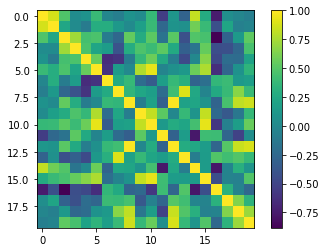

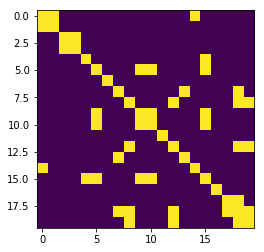

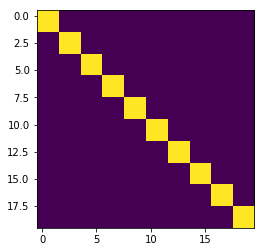

Compute the 2D overlap in the matrix:
test_jaccard_score: 0.885
test_f1_score: 0.5306122448979592
test_accuracy_score: 0.885


In [9]:
sentences_raw = (
    "This is a test. This is another test. "
    "I like bacon. I don't like bacon. "
    "My name is Guillaume. My family name is Chevalier. "
    "Programming can be used for solving complicated math problems. Let's use the Python language to write some scientific code. "
    "My family regrouped for Christmast. We met aunts and uncles. "
    "I like linux. I have an operating system. "
    "Have you ever been in the situation where you've got Jupyter notebooks (iPython notebooks) so huge that you were feeling stuck in your code?. Or even worse: have you ever found yourself duplicating your notebook to do changes, and then ending up with lots of badly named notebooks?. "
    "Either and in any ways. For every medium to big application. "
    "If you're working with notebooks, it is highly likely that you're doing research and development. If doing research and development, to keep your amazing-10x-working-speed-multiplier, it might be a good idea to skip unit tests. "
    "I hope you were satisfied by this reading. What would you do?."
).split(". ")  # each 2 sentence (pairs) above are similar, so we have 10 pairs as such:
category_per_sentence = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]

plot_a_result(
    category_per_sentence, cuda_device_id, preproc_sgnn_sklearn_pipeline, 
    sentence_projection_model, sentences_raw)

The last plot is the expected diagonal block matrix (blocs of 2x2), and the top plot is the prediction. Mid plot is what is above 1 std in the prediction.